## Importar librerías

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers
import yaml
import json

# API OpenALEX

In [2]:
url = 'https://api.openalex.org/works/https://doi.org/10.1057/s41267-022-00512-y'
# url = 'https://api.openalex.org/institutions/https://ror.org/018906e22'
response = requests.get(url)
if(response.status_code in [200,201]):
    data= response.json()
    with open('archivo.json', 'w') as file:
        json.dump(data, file, indent=4)
else:
    print('MALLLLL')
# print(data1)
response.close()


# json_str = json.dumps(data1, indent=4)
# # print(json_str)

# with open('uItils\peluso.json', 'w') as file:
#     json.dump(data1, file, indent=4)

# ror = 'https://api.openalex.org/works/' +  data1['authorships'][0]['institutions'][0]['ror']
# print(ror)
# # response1 = requests.get(ror)

# # if(response1.status_code in [200,201]):
# #     data2 = response1.json()

# # print(data2)

# # if(response.status_code in [200,201]):

# #     data2 = response.json()
# print(data2)


# URL instituciones

In [3]:
dict_orgID = {}
dict_authID = {}

id_org = []
# id_auth = []

# Inserta ID a las organizaciones #
def obtener_o_actualizar_valor(diccionario, clave):
    if clave in diccionario:
        return diccionario[clave]
    else:
        if len(diccionario) == 0:
            siguiente_valor = 1
        else:
            siguiente_valor = max(diccionario.values()) + 1
        diccionario[clave] = siguiente_valor
        return siguiente_valor


# # En base a una lista dada, genera una lista de diccionarios con ese elemento #
# def generar_diccionarios(lista, nombre):
#     lista_diccionarios = []
#     for elemento in lista:
#         diccionario = {nombre: elemento}
#         lista_diccionarios.append(diccionario)
#     return lista_diccionarios


# Genera una Etiqueta 'Organization' con una lista vacia para cada Autor #
def listaOrgInsert(json_datos):
    data = json.loads(json_datos)
    for block in data['Paper']:
        # Recorrer cada subbloque de la sección "Author"
        for author in block["Author"]:
            # Agregar la etiqueta "Institucion" como una lista vacía
            author["Organization"] = []
    modified_json = json.dumps(data, indent=4)
    return modified_json


#  #
def listaOrgInsert(json_datos):
    data = json.loads(json_datos)
    for block in data['Paper']:
        # Recorrer cada subbloque de la sección "Author"
        for author in block["Author"]:
            # Agregar la etiqueta "Institucion" como una lista vacía
            author["Organization"] = []
    modified_json = json.dumps(data, indent=4)
    return modified_json



# Obtener URL de la organización llamando a la API por ROR #
def getOrgURL(ror):
    homepage=''
    if ror is not None:
        url = 'https://api.openalex.org/institutions/' + ror
        response = requests.get(url)
        
        if(response.status_code in [200,201]):
            datos= response.json()
            homepage = datos['homepage_url']
        else:
            homepage = 'None'  
    else:
        homepage = 'None'
    return homepage

# Realimenta nuestros datos con datos extraidos de OpenAlex #
def openalexRefeed(jsonDump) :
    datos = json.loads(jsonDump)
    i=0
    for paper in datos['Paper']:
        i = i+1
        url = 'https://api.openalex.org/works/' + paper['DOI']
        response = requests.get(url)
        if(response.status_code in [200,201]):
            data= response.json()
        paper['PublicationDate'] = data["created_date"]
        paper['PublicationHost'] = data['primary_location']['source']['host_organization_name']
        total_authorships = len(data['authorships'])
        # Recorrer todas las combinaciones de 'n' y 'm'
        for n in range(total_authorships):
            id_org=[]
            institutions = data['authorships'][n]['institutions']
            total_institutions = len(institutions)
            for m in range(total_institutions):
                if institutions[m]['display_name'] is not None:
                    orgName = institutions[m]['display_name']
                    if institutions[m]['ror'] is not None:
                        orgROR = institutions[m]['ror']
                    else:
                        orgROR = 'None'
                    orgURL = getOrgURL(orgROR)
                    orgID = obtener_o_actualizar_valor(dict_orgID, orgName)
                    # IFs para las listas de Identificadores
                    if orgID not in id_org:
                        id_org.append(orgID)

                    bloque_insert = {'OrgID': orgID,'OrgName': orgName, 'OrgURL': orgURL, 'OrgROR': orgROR}

                    try:
                        paper['Author'][n]['Organization'].append(bloque_insert)
                        paper['Author'][n]['Organizations_IDs'] = id_org

                    except:
                        continue
        grants = data['grants']
        grant_list = []
        for grant in grants:
            grantName = grant['funder_display_name']
            grant_list.append(grantName)
        proj_insert = {'ID_Project': i, 'projectName':grant_list}
        paper['Project'] = proj_insert
    # modified_json = json.dumps(datos, indent=4)
    return datos

def añadirIDAuth(jsonDump):
    for paper in jsonDump['Paper']:
        id_auth = []  # Crear una nueva lista para cada paper
        
        for autor in paper['Author']:
            nombre = autor['Forename'] + autor['Surname']
            id = obtener_o_actualizar_valor(dict_authID, nombre)
            if id not in id_auth:        
                id_auth.append(id)
            autor['ID_Author'] = id
        
        paper['AuthorIDs'] = id_auth


        


In [4]:
# Ruta al archivo JSON
ruta_archivo = 'alvaritingo.json'

# Lee el contenido del archivo JSON
with open(ruta_archivo, 'r') as archivo:
    contenido_json = archivo.read()

json_bien = listaOrgInsert(contenido_json)
json_completo = openalexRefeed(json_bien)


In [5]:
añadirIDAuth(json_completo)
i=1
for paper in json_completo['Paper']:
# for paper in json_completo['Paper']:
        paper['ID_Paper'] = i
        paper['Project']['PaperID'] = i
        i=i+1

# with open('papers_completo.json', 'w') as file:
#         json.dump(json_completo, file, indent=4)

## Ingesta de abstracts

In [6]:
abstracts = []

# Extraer los 'Abstracts'
for paper in json_completo['Paper']:
    abstract = paper['Abstract']
    abstracts.append(abstract)

# Crear el DataFrame
df = pd.DataFrame({'ID': range(1, len(abstracts) + 1),
                   'Abstract': abstracts})

# Mostrar el DataFrame
print(df)

    ID                                           Abstract
0    1  This systematic literature review aimed to pro...
1    2  Background. The coronavirus disease 2019 (COVI...
2    3  The risk of a zoonotic pandemic disease threat...
3    4  Background: Antimicrobial resistance in Mycopl...
4    5  human remains do not pose a risk for outbreaks...
5    6  The global pandemic of coronavirus disease 201...
6    7  Since January 2020 Elsevier has created a COVI...
7    8  Since January 2020 Elsevier has created a COVI...
8    9  Background: We assessed the utility of a multi...
9   10  Background: Communicable disease reporting and...
10  11  Since January 2020 Elsevier has created a COVI...
11  12  on behalf of the BCoDE consortium. Impact of i...
12  13  In today's globalized world, rapid urbanizatio...
13  14  Since January 2020 Elsevier has created a COVI...
14  15  Introduction: To obtain necessary information ...
15  16  Although the majority of travel-associated com...
16  17  Backgr

## Transformación de dataset quitando stopwords

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Función para eliminar las stopwords de un texto dado
def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word.lower() not in stop_words])

# Aplicar la función remove_stopwords() a la columna "Abstract" del DataFrame
abstract_no_stopwords = df["Abstract"].apply(remove_stopwords)

In [9]:
print(abstract_no_stopwords)

0     systematic literature review aimed provide ove...
1     Background. coronavirus disease 2019 (COVID-19...
2     risk zoonotic pandemic disease threatens hundr...
3     Background: Antimicrobial resistance Mycoplasm...
4     human remains pose risk outbreaks (4). Dead bo...
5     global pandemic coronavirus disease 2019 (COVI...
6     Since January 2020 Elsevier created COVID-19 r...
7     Since January 2020 Elsevier created COVID-19 r...
8     Background: assessed utility multi-target, rea...
9     Background: Communicable disease reporting sur...
10    Since January 2020 Elsevier created COVID-19 r...
11    behalf BCoDE consortium. Impact infectious dis...
12    today's globalized world, rapid urbanization, ...
13    Since January 2020 Elsevier created COVID-19 r...
14    Introduction: obtain necessary information man...
15    Although majority travel-associated communicab...
16    Background: Salmonella induced infections rema...
17    China one largest countries world nearly 2

## Similitud coseno

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# vectorize the documents using TF-IDF
vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer()
X = vectorizer.fit_transform(abstract_no_stopwords)

# with sentence transformers it's something like:
#sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
#sentence_embeddings = sbert_model.encode(sentences)
#cosine(sentence_embeddings[0],sbert_model.encode(["Productos de la agricultura, ganadería, pesca, silvicultura y productos afines"])[0])

# compute the cosine similarity matrix
cos_sim_matrix = cosine_similarity(X)
cos_sim_matrix

array([[1.        , 0.01907152, 0.05579614, 0.02313082, 0.        ,
        0.17689257, 0.01062228, 0.01062228, 0.03244405, 0.09871494,
        0.01062228, 0.2132129 , 0.05420079, 0.01062228, 0.10009488,
        0.02435193, 0.02470647, 0.08458802, 0.08344698, 0.01573242,
        0.14305182, 0.04765605, 0.0737235 , 0.09767167, 0.10633075,
        0.08913753, 0.08925723, 0.10259888, 0.04426273, 0.0728495 ],
       [0.01907152, 1.        , 0.08082293, 0.01355784, 0.        ,
        0.24071208, 0.15138032, 0.15138032, 0.01942902, 0.03308732,
        0.15138032, 0.        , 0.04061882, 0.15138032, 0.03864138,
        0.        , 0.06513023, 0.05982704, 0.0646272 , 0.01645761,
        0.        , 0.04773519, 0.07130269, 0.05623108, 0.03432844,
        0.        , 0.04167705, 0.01571971, 0.0495582 , 0.        ],
       [0.05579614, 0.08082293, 1.        , 0.        , 0.01939038,
        0.11273932, 0.        , 0.        , 0.00557595, 0.02383981,
        0.        , 0.04635286, 0.06247996, 0.

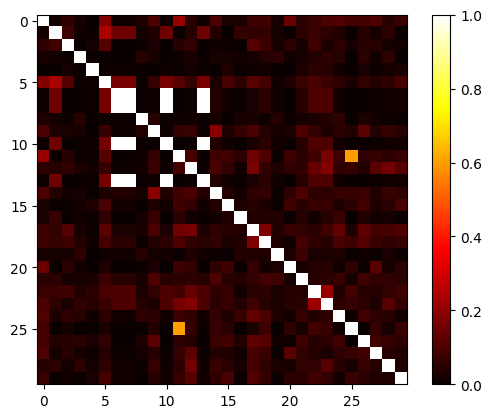

In [12]:
# Crea el mapa de calor
plt.imshow(cos_sim_matrix, cmap='hot', interpolation='nearest')

# Agrega la barra de color
plt.colorbar()

# Muestra el gráfico
plt.show()

## Importar modelo y definir variables

In [13]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C

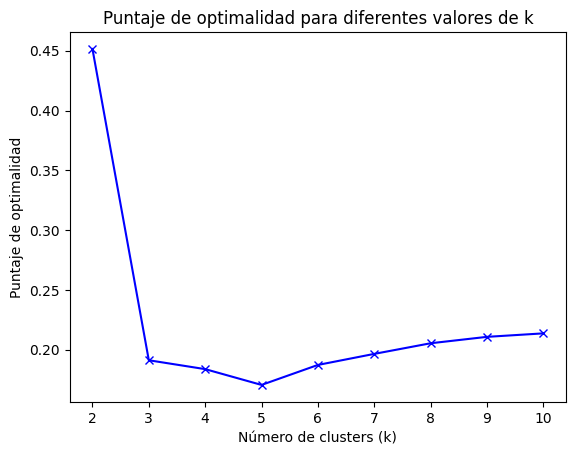

In [29]:
k_values = range(2, 11)

# Inicializar una lista para almacenar los puntajes de optimalidad
optimalidad_scores = []

# Iterar sobre diferentes valores de k
for k in k_values:
    # Crear un modelo K-means con el valor actual de k
    kmeans = KMeans(n_clusters=k)
    
    # Ajustar el modelo a los datos
    kmeans.fit(cos_sim_matrix)
    
    # Obtener las etiquetas de los clusters y calcular el puntaje de optimalidad
    labels = kmeans.labels_
    score = silhouette_score(cos_sim_matrix, labels)
    
    # Agregar el puntaje a la lista de puntajes de optimalidad
    optimalidad_scores.append(score)

# Graficar los puntajes de optimalidad en función de los valores de k
plt.plot(k_values, optimalidad_scores, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Puntaje de optimalidad')
plt.title('Puntaje de optimalidad para diferentes valores de k')
plt.savefig('kmeans.png')

C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C

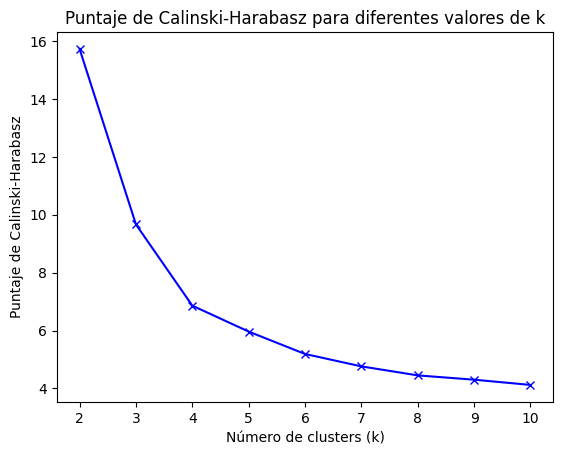

In [30]:


k_values = range(2, 11)
optimalidad_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(cos_sim_matrix)
    labels = kmeans.labels_
    score = calinski_harabasz_score(cos_sim_matrix, labels)
    optimalidad_scores.append(score)

plt.plot(k_values, optimalidad_scores, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Puntaje de Calinski-Harabasz')
plt.title('Puntaje de Calinski-Harabasz para diferentes valores de k')
plt.savefig('Calinski-Harabasz.png')

In [16]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
labels = clustering.fit_predict(cos_sim_matrix)

#kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300)
#labels = kmeans.fit_predict(cos_sim_matrix)
#dbscan = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
#labels = dbscan.fit_predict(cos_sim_matrix)

# print the clusters
df = pd.DataFrame({'abstract': abstract_no_stopwords, 'cluster': labels})
print(df)

                                             abstract  cluster
0   systematic literature review aimed provide ove...        0
1   Background. coronavirus disease 2019 (COVID-19...        1
2   risk zoonotic pandemic disease threatens hundr...        0
3   Background: Antimicrobial resistance Mycoplasm...        0
4   human remains pose risk outbreaks (4). Dead bo...        1
5   global pandemic coronavirus disease 2019 (COVI...        1
6   Since January 2020 Elsevier created COVID-19 r...        1
7   Since January 2020 Elsevier created COVID-19 r...        1
8   Background: assessed utility multi-target, rea...        0
9   Background: Communicable disease reporting sur...        0
10  Since January 2020 Elsevier created COVID-19 r...        1
11  behalf BCoDE consortium. Impact infectious dis...        0
12  today's globalized world, rapid urbanization, ...        0
13  Since January 2020 Elsevier created COVID-19 r...        1
14  Introduction: obtain necessary information man...  

C:\Users\Miguel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [17]:
# Now let's do topic modeling using LDA
from sklearn.decomposition import LatentDirichletAllocation
num = 2
# let's do a countvectorizer now
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(abstract_no_stopwords)
# we are only creating 2 topics
lda = LatentDirichletAllocation(n_components=num, random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=2, random_state=0)

In [18]:
# feature_names = count_vectorizer.get_feature_names_out() 
# for topic_id, topic in enumerate(lda.components_):
#     print(f"Topic {topic_id}:")
#     print(" ".join([feature_names[i] for i in topic.argsort()[:-6:-1]]))
feature_names = count_vectorizer.get_feature_names_out()
topic_keywords = []

for topic_id, topic in enumerate(lda.components_):
    keywords = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    topic_keywords.append(keywords)

# topic_keywords contendrá las listas de keywords para cada topic
print(topic_keywords)

[['disease', 'diseases', 'infectious', 'communicable', 'health'], ['covid', '19', 'centre', 'research', 'health']]


In [23]:
# Crear lista de diccionarios con la información de cada fila
rows = []
i = 0
for abstract in df['abstract']:
    new_doc_bow = vectorizer.transform(['{}'.format(abstract)])
    topic_distribution = lda.transform(new_doc_bow)
    row = {'Abstract': abstract, 'Topic 1': topic_distribution[0][0], 'Topic 2': topic_distribution[0][1]}
    rows.append(row)
    i += 1

df_new = pd.DataFrame(rows)

total_rows = df_new.shape[0]
paper_ids = range(1, total_rows + 1)

# Agregar la columna "PaperID" al DataFrame
df_new["PaperID"] = paper_ids

df_new

,Abstract,Topic 1,Topic 2,PaperID
0,systematic literature review aimed provide ove...,0.941091,0.058909,1
1,Background. coronavirus disease 2019 (COVID-19...,0.579685,0.420315,2
2,risk zoonotic pandemic disease threatens hundr...,0.891960,0.108040,3
3,Background: Antimicrobial resistance Mycoplasm...,0.065190,0.934810,4
4,human remains pose risk outbreaks (4). Dead bo...,0.107460,0.892540,5
5,global pandemic coronavirus disease 2019 (COVI...,0.656615,0.343385,6
6,Since January 2020 Elsevier created COVID-19 r...,0.077141,0.922859,7
7,Since January 2020 Elsevier created COVID-19 r...,0.077141,0.922859,8
8,"Background: assessed utility multi-target, rea...",0.936538,0.063462,9
9,Background: Communicable disease reporting sur...,0.937293,0.062707,10


In [24]:
def get_topic_id(id, df):
    row = df[df["PaperID"] == id]  # Obtener la fila correspondiente al PaperID
    topic1_value = row["Topic 1"].values[0]  # Obtener el valor de Topic 1
    topic2_value = row["Topic 2"].values[0]  # Obtener el valor de Topic 2
    
    if topic1_value > topic2_value:
        return 1
    elif topic2_value > topic1_value:
        return 2
    else:
        return None  # Si ambos valores son iguales, devuelve None o puedes manejar otro caso según tu necesidad


In [27]:
for paper in json_completo['Paper']:
    # Realizar las operaciones que desees con cada fila correspondiente a paper_id
    topic_selected = get_topic_id(paper['ID_Paper'], df_new)

    # accuracy1 = df_new.loc[df["PaperID"] == paper['ID_Paper'], "Topic 1"].values[0]
    # accuracy2 = df_new.loc[df["PaperID"] == paper['ID_Paper'], "Topic 2"].values[0]
    # result_1 = {"ID_Result": 1, "accuracy": accuracy1, "PaperID": paper['ID_Paper']}
    # result_2 = {"ID_Result": 2, "accuracy": accuracy2, "PaperID": paper['ID_Paper']}
    # paper['Result'] = [result_1, result_2]

    if(topic_selected == 1):
        paper['Topic'] = {"Topic_name": 'Topic{}'.format(topic_selected), "KeyWords": topic_keywords[0], 'ResultID':1}
        accuracy1 = df_new.loc[df_new["PaperID"] == paper['ID_Paper'], "Topic 1"].values[0]
        result_1 = {"ID_Result": 1, "accuracy": accuracy1, "PaperID": paper['ID_Paper']}
        paper['Result'] = result_1


    if(topic_selected == 2):
        paper['Topic'] = {"Topic_name": 'Topic{}'.format(topic_selected), "KeyWords": topic_keywords[1], 'ResultID':2}
        accuracy2 = df_new.loc[df_new["PaperID"] == paper['ID_Paper'], "Topic 2"].values[0]
        result_2 = {"ID_Result": 2, "accuracy": accuracy2, "PaperID": paper['ID_Paper']}
        paper['Result'] = result_2


with open('papers_completo.json', 'w') as file:
    json.dump(json_completo, file, indent=4)

In [57]:
accuracy1 = df_new.loc[df["PaperID"] == 1, "Topic 1"].values[0]
print(accuracy1)

0.9410911475876829


In [58]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calcular el coeficiente de silueta
silhouette_coefficient = silhouette_score(cos_sim_matrix, df['cluster'])
print("Coeficiente de silueta: {:.4f}".format(silhouette_coefficient))

# Calcular el índice de Davies-Bouldin
davies_bouldin_index = davies_bouldin_score(cos_sim_matrix, df['cluster'])
print("Índice de Davies-Bouldin: {:.4f}".format(davies_bouldin_index))

Coeficiente de silueta: 0.2562
Índice de Davies-Bouldin: 1.5295


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Obtener los centroides de los clusters
centroides = kmeans.cluster_centers_

# Calcular las distancias coseno entre cada abstract y su centroide
distancias = cosine_distances(abstracts_embeddings, centroides)

# Calcular la pertenencia al cluster como la inversa de las distancias
pertenencia = 1 - distancias

# Imprimir la pertenencia al cluster para cada abstract
for i, abstract in enumerate(abstracts):
    print("Abstract {}: Pertinencia al Cluster {}: {:.4f}".format(i, labels[i], pertenencia[i][labels[i]]))


## Fit de nuestros datos y análisis de resultados